In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import choice
import warnings

%matplotlib inline

https://www.neverstopbuilding.com/blog/2013/12/13/tic-tac-toe-understanding-the-minimax-algorithm13  
https://github.com/khpeek/Q-learning-Tic-Tac-Toe

### Outline:
- Game  
-- instantiates new Players, or accesses provided Players    
-- instantiates the Board  
-- keeps track of whose turn it is  
-- passes Board to Players when asking for a move, then updates Board with move  
-- keeps track of game outcome
- Board  
-- the board that is updated over the course of the game
- Player  
-- can exist on its own outside of Game  
-- has a policy  
-- selects a move  
-- can calculate if a board state is a win/loss/tie
-- remembers Board state from Player's previous move, and updates policy if needed  
-- if set to 'human', the Player just asks the human for input for each move

# Classes

In [2]:
class ttt_board(object):
    
    def __init__(self):
        self.spaces = ['_'] * 9
        
    def __str__(self):
        # Allow for printing of board in human-readable format
        return '%s\n%s\n%s\n' % (' '.join(self.spaces[:3]), ' '.join(self.spaces[3:6]), ' '.join(self.spaces[6:]))
    
    def update(self, ix, mark):
        """
        Updates the board with a new X or O.
        """
        self.spaces[ix] = mark

    
class ttt_player(object):
    
    def __init__(self, player_type, mark, epsilon=.9, alpha=.1):
        self.player_type = player_type
        self.mark = mark
        self.board_vals = [2**i for i in range(9)]
        if player_type == 'computer':
            self.policy = dict()
            self.alpha = alpha            # learning rate
            self.epsilon = epsilon        # exploration rate
            self.prev_state = None
    
    
    def __str__(self):
        return 'Player %s' % self.mark
    
    
    def set_epsilon(self, epsilon):
        """
        Sets the player's exploration rate. This is the rate at which the player explores move options that
        *don't* have the highest win probability based on the player's current policy.
        """
        self.epsilon = epsilon
    
    
    def set_alpha(self, alpha):
        """
        Sets the player's learning rate. This indicates how much the player should adjust its win probabilities
        based on new information.
        """
        self.alpha = alpha
    
    
    def get_player_total(self, state):
        """
        Returns a total for each player based on values I've assigned to each space on the board.
        This enables us to easily know if someone has won the game.
        """
        total = 0
        for i, x in enumerate(state):
            if x == self.mark:
                total += self.board_vals[i]
        return total
    
    
    def get_move_outcome(self, state):
        """
        Informs the player that the given state is a win, draw, or none of the above. Uses bitwise operations to
        translate the board state into an indication of a win. See explanation here:
        http://mamallamacoding.blogspot.com/2014/03/making-tictactoe-with-object-oriented.html
        """
        win_totals = [7, 56, 448, 73, 146, 292, 273, 84]
        total = self.get_player_total(state)
        for val in win_totals:
            if total & val == val: # bitwise operation!
                return 'win'
        if '_' not in state:
            return 'draw'
        return None
    
    
    def get_prob_from_policy(self, state):
        """
        This function returns a player's current understanding of its probability of winning from a given
        board state. If the player has never seen this state before, the function fills the player's policy with
        a 1 if it's a win state (e.g. three X's in a row), a .5 if it's a draw state, or a .5 if it's an unknown
        state prior to the end of the game.
        
        (A player will never store a lose state in its policy [e.g. three O's in a row if you are player X] 
        because the player will not make any more moves after it has lost.)
        """
        state = tuple(state)
        if state in self.policy:
            return self.policy[state]
        
        outcome = self.get_move_outcome(state)
        if outcome == 'win':
            self.policy[state] = 1
        elif outcome == 'draw':
            self.policy[state] = .5
        else:                       # Fill with .5 if winner hasn't been decided yet
            self.policy[state] = .5
        return self.policy[state]

                                   
    def update_policy(self, current_win_prob, board, state):
        """
        Updates the win probability of a previous state based on the win probability of the current state.
        """
        prev_state = tuple(self.prev_state)
        prev_win_prob = self.policy[prev_state]
        self.policy[prev_state] = prev_win_prob + self.alpha*(current_win_prob - prev_win_prob)
        
        
    def get_move(self, board, print_output):
        """
        Gets a move from a human or computer player.
        returns: index of the board space that the player wants to make an X or O in (ix from 0-8)
        """
        if self.player_type == 'human':
            while True:
                try:
                    row_index, col_index = eval(raw_input( \
                                "Enter the row and column you want to make a mark in, using the format x,y "))
                    # Get correct index in the board list, adjusting for 0-indexing
                    move_index = (row_index-1)*3 + col_index - 1
                    if board.spaces[move_index] == '_':
                        return move_index
                except:
                    pass
                print "Invalid move.\n"
        
        # Make Computer player decision
        state = board.spaces[:]
        possible_move_indices = [i for i, x in enumerate(state) if x == '_']
        
        if np.random.uniform() < self.epsilon:     # randomly choose a move with probability = epsilon
            move_index = choice(possible_move_indices)
            next_state = state[:]
            next_state[move_index] = self.mark
            _ = self.get_prob_from_policy(next_state) # I don't use the result, but this function fills the
                            # policy with a win probability for this state if this state key doesn't already exist
        
        else:               # Choose the best known move with probability = 1-epsilon
            max_prob = 0
            best_move_ixs = []
            for i in possible_move_indices:
                potential_state = state[:]
                potential_state[i] = self.mark
                prob = self.get_prob_from_policy(potential_state)
                
                # Treat win probabilities that are equal up to the 3rd decimal place as equivalent for
                # the purpose of choosing a move
                if np.isclose(prob, max_prob, rtol=0, atol=10**-4):
                        best_move_ixs.append(i)
                elif prob > max_prob:
                        best_move_ixs = [i]
                        max_prob = prob
            if print_output:
                print 'best move ixs: ', best_move_ixs
                print 'max_prob: ', max_prob
            move_index = choice(best_move_ixs)
            if self.prev_state:
                self.update_policy(max_prob, board, state)  

        self.prev_state = state
        self.prev_state[move_index] = self.mark
        return move_index
                            
            
# Game object instantiates the board and human or CPU players
class ttt_game(object):
    
    def __init__(self, playerX, playerO, print_output = True):
        self.board = ttt_board()
        if isinstance(playerX, ttt_player):
            if playerX.mark == 'X':
                self.playerX = playerX
                self.playerX.prev_state = None
            else:
                raise ValueError('playerX must have player mark "X".')
        elif playerX == 'human':
            self.playerX = ttt_player('human', 'X')
        elif playerX == 'computer':
            self.playerX = ttt_player('computer', 'X')
        else:
            raise ValueError('playerX must be a ttt_player object, or it must be a string indicating "human" or "computer."')
          
        if isinstance(playerO, ttt_player):
            if playerO.mark == 'O':
                self.playerO = playerO
                self.playerO.prev_state = None
            else:
                raise ValueError('playerO must have player mark "O".')
        elif playerO == 'human':
            self.playerO = ttt_player('human', 'O')
        elif playerO == 'computer':
            self.playerO = ttt_player('computer', 'O')
        else:
            raise ValueError('playerO must be a ttt_player object, or it must be a string indicating "human" or "computer."')
               
        self.playerX_score = []
        self.playerO_score = []
        self.current_player = self.playerX
        self.print_output = print_output
        
        
    def set_print(self, print_output):
        """
        Sets the print_output attribute. If True, ttt_game will print the board at each move, say whose turn
        it is, and state the outcome of each game.
        print_output: True or False
        """
        self.print_output = print_output
    
    
    def take_a_turn(self):
        """
        Asks the current player to select its next move.
        """
        if self.print_output:
            print "%s's turn:" % self.current_player
        move_index = self.current_player.get_move(self.board, self.print_output)
        self.board.update(move_index, self.current_player.mark)
        if self.current_player == self.playerX:
            self.current_player = self.playerO
        else:
            self.current_player = self.playerX
        if self.print_output:
            print self.board
        
        
    def game_outcome(self):
        """
        Returns information on wins or ties, or returns None if the game is not yet over.
        """
        state = self.board.spaces
        win_totals = [7, 56, 448, 73, 146, 292, 273, 84]
        X_total = self.playerX.get_player_total(state)
        O_total = self.playerO.get_player_total(state)
        for val in win_totals:
            if X_total & val == val:        # Bitwise operation!
                self.playerX_score.append(1)
                self.playerO_score.append(0)
                return 'Player X wins!'
            if O_total & val == val:
                self.playerO_score.append(1)
                self.playerX_score.append(1)
                return 'Player O wins!'
        if '_' not in state:
            self.playerX_score.append(.5)
            self.playerO_score.append(.5)
            return 'The game is a tie!'
        return None

                                   
    def send_game_end_signal(self, outcome):
        """
        The "current player" is the player who took the penultimate turn. We send that player information on
        the game outcome, so that player can adjust its policy.
        """
        penultimate_player = self.current_player
        if outcome == 'The game is a tie!':
            win_prob = .5
        else:
            win_prob = 0
        if penultimate_player.player_type == 'computer':
            penultimate_player.update_policy(win_prob, self.board, self.board)   
    
    
    def play(self):
        """
        Plays a game of tic tac toe.
        """
        if self.print_output:
            print self.board
        outcome = self.game_outcome()
        while not (outcome):
            self.take_a_turn()
            outcome = self.game_outcome()
        self.send_game_end_signal(outcome)
        if self.print_output:
            print outcome
      
    
    def reset(self):
        """
        Resets board and certain player attributes in preparation for a new game.
        """
        self.board = ttt_board()
        self.playerX.prev_state = None
        self.playerO.prev_state = None
        self.current_player = self.playerX

     
    def get_player_score(self, player):
        """
        Returns all scores (win statistics) for the given player.
        player: string indicating 'playerX' or 'playerO'
        """
        if player == 'playerX':
            return self.playerX_score
        if player == 'playerO':
            return self.playerO_score
        raise ValueError('player should be either "playerX" or "playerO"')

            

# Helper functions

In [ ]:
def print_board(state):
    """
    state: list of strings that indicates the board state
    """
    print '%s\n%s\n%s' % (' '.join(state[:3]), ' '.join(state[3:6]), ' '.join(state[6:]))
                          

def train_computer_players(playerX, playerO, n_games=200000, adj_pX_epsilon=True, adj_pO_epsilon=True):
    """
    Trains an "X" computer player and an "O" computer player on 200000 games of tic tac toe.
    By default, player exploration rate is set high to learn quickly, and then is decreased according
    to the following scheme:
    .9 for first 50% of games, .5 for next 40%, 0.0 for the last 10%
    
    If adj_p_epsilon is set to False, the player's exploration rate will remain as it was before
    calling this function.
    """
    if adj_pX_epsilon:
        playerX.set_epsilon(.9)
    if adj_pO_epsilon:
        playerO.set_epsilon(.9)
    game = ttt_game(playerX, playerO, print_output = False)
    for i in range(1, n_games+1):
        if i/float(n_games) >= .5:
            if i/float(n_games) >= .9:
                if adj_pX_epsilon:
                    playerX.set_epsilon(0)
                if adj_pO_epsilon:
                    playerO.set_epsilon(0)
            else:
                if adj_pX_epsilon:
                    playerX.set_epsilon(.2)
                if adj_pO_epsilon:
                    playerO.set_epsilon(.2)
        game.play()
        game.reset()
    return game
        

def test_computer(computer_player, n_games=3):
    """
    Used when a human wants to evaluate a computer player.
    This function plays n_games with a human versus the computer_player.
    """    
    #computer_player.set_epsilon(0)
    if computer_player.mark == 'X':
        game = ttt_game(computer_player, 'human', print_output=True)
    if computer_player.mark == 'O':
        game = ttt_game('human', computer_player, print_output=True)
    for i in range(n_games):
        game.play()
        game.reset()
        
        
def explore_policy(state, player):
    """
    Given a board state, this function shows all possible next moves for a player and the probability of winning
    from those next moves, according to the player's policy.
    state: list of strings indicating the board state
    player: ttt_player object 
    """
    print_board(state)
    print 'Initial board state\n'
    possible_move_indices = [i for i, x in enumerate(state) if x == '_']
    for i in possible_move_indices:
        potential_state = state[:]
        potential_state[i] = player.mark        
        print_board(potential_state)
        print 'Win probability = %.17f\n' % player.policy[tuple(potential_state)]
    
    
def compute_player_stats(game, player, n_groups=100):
    scores = pd.DataFrame(game.get_player_score(player))
    scores.columns = ['score']
    scores['win_draw'] = (scores.score != 0).astype(int)
    group_size = len(scores)/n_groups
    if group_size == 0:
        warnings.warn('This player has fewer scores than n_groups. Scores will not be aggregated.')
        group_size = 1
    scores_agg = scores.groupby(scores.index/group_size).win_draw.aggregate(lambda x: x.sum()/float(x.shape[0]))
    return scores, scores_agg

In [34]:
player1 = ttt_player('computer', 'X', epsilon=.9)
player2 = ttt_player('computer', 'O', epsilon=1)
#player2.alpha = 0

In [35]:
p1_2_training_game = train_computer_players(player1, player2, n_games=200000)

In [14]:
#p1_2_real_game = train_computer_players(player1, player2, n_games=100000, adj_pO_epsilon=False, adj_pX_epsilon=False)

In [33]:
state = ['_', '_', '_', '_', '_', '_', '_', '_', '_']
explore_policy(state, player1)

_ _ _
_ _ _
_ _ _
Initial board state

X _ _
_ _ _
_ _ _
Win probability = 0.98535518590140225

_ X _
_ _ _
_ _ _
Win probability = 0.98587345495534184

_ _ X
_ _ _
_ _ _
Win probability = 0.98559850343492372

_ _ _
X _ _
_ _ _
Win probability = 0.98593878817146230

_ _ _
_ X _
_ _ _
Win probability = 0.99637483431855367

_ _ _
_ _ X
_ _ _
Win probability = 0.98491927362704523

_ _ _
_ _ _
X _ _
Win probability = 0.98517409148066726

_ _ _
_ _ _
_ X _
Win probability = 0.98593791804318998

_ _ _
_ _ _
_ _ X
Win probability = 0.98531265299264104



In [ ]:
#### After real games
state = ['_', '_', '_', '_', '_', '_', '_', '_', '_']
explore_policy(state, player1)

In [30]:
state = ['X', '_', '_', '_', '_', '_', '_', '_', '_']
explore_policy(state, player2)

X _ _
_ _ _
_ _ _
Initial board state

X O _
_ _ _
_ _ _
Win probability = 0.50000000000000000

X _ O
_ _ _
_ _ _
Win probability = 0.50000000000000000

X _ _
O _ _
_ _ _
Win probability = 0.50000000000000000

X _ _
_ O _
_ _ _
Win probability = 0.50000000000000000

X _ _
_ _ O
_ _ _
Win probability = 0.50000000000000000

X _ _
_ _ _
O _ _
Win probability = 0.50000000000000000

X _ _
_ _ _
_ O _
Win probability = 0.50000000000000000

X _ _
_ _ _
_ _ O
Win probability = 0.50000000000000000



In [67]:
# After real games
state = ['X', '_', '_', '_', '_', '_', '_', '_', '_']
explore_policy(state, player2)

X _ _
_ _ _
_ _ _
Initial board state

X O _
_ _ _
_ _ _
Win probability = 0.18737530654001841

X _ O
_ _ _
_ _ _
Win probability = 0.24214233007289510

X _ _
O _ _
_ _ _
Win probability = 0.18838534308654881

X _ _
_ O _
_ _ _
Win probability = 0.50000000538575251

X _ _
_ _ O
_ _ _
Win probability = 0.32048128414295668

X _ _
_ _ _
O _ _
Win probability = 0.33452838754375175

X _ _
_ _ _
_ O _
Win probability = 0.24745382114959777

X _ _
_ _ _
_ _ O
Win probability = 0.24302427569023763



In [8]:
state = ['_', '_', '_', 'X', '_', '_', '_', '_', '_']
explore_policy(state, player2)

_ _ _
X _ _
_ _ _
Initial board state

O _ _
X _ _
_ _ _
Win probability = 0.50001414832167068

_ O _
X _ _
_ _ _
Win probability = 0.28616200204709702

_ _ O
X _ _
_ _ _
Win probability = 0.38382233248558001

_ _ _
X O _
_ _ _
Win probability = 0.50000891392253322

_ _ _
X _ O
_ _ _
Win probability = 0.50001442069110003

_ _ _
X _ _
O _ _
Win probability = 0.50068053430214110

_ _ _
X _ _
_ O _
Win probability = 0.22228104457487960

_ _ _
X _ _
_ _ O
Win probability = 0.31550165713188472



In [68]:
# After real games
state = ['_', '_', '_', 'X', '_', '_', '_', '_', '_']
explore_policy(state, player2)

_ _ _
X _ _
_ _ _
Initial board state

O _ _
X _ _
_ _ _
Win probability = 0.50000154888162762

_ O _
X _ _
_ _ _
Win probability = 0.34899297254332839

_ _ O
X _ _
_ _ _
Win probability = 0.28274182107305290

_ _ _
X O _
_ _ _
Win probability = 0.50000000145701207

_ _ _
X _ O
_ _ _
Win probability = 0.50001179977088361

_ _ _
X _ _
O _ _
Win probability = 0.50001307638968384

_ _ _
X _ _
_ O _
Win probability = 0.24150384190829743

_ _ _
X _ _
_ _ O
Win probability = 0.24388400735064977



In [39]:
test_computer(player1, n_games=1)

_ _ _
_ _ _
_ _ _

Player X's turn:
best move ixs:  [0, 1, 2, 3, 4, 5, 6, 7, 8]
max_prob:  0.5
X _ _
_ _ _
_ _ _

Player O's turn:
Enter the row and column you want to make a mark in, using the format x,y 2,2
X _ _
_ O _
_ _ _

Player X's turn:
best move ixs:  [1, 2, 3, 5, 6, 7, 8]
max_prob:  0.5
X _ _
_ O _
_ X _

Player O's turn:
Enter the row and column you want to make a mark in, using the format x,y 3,1
X _ _
_ O _
O X _

Player X's turn:
best move ixs:  [2]
max_prob:  0.5
X _ X
_ O _
O X _

Player O's turn:
Enter the row and column you want to make a mark in, using the format x,y 1,2
X O X
_ O _
O X _

Player X's turn:
best move ixs:  [3, 5, 8]
max_prob:  0.5
X O X
_ O _
O X X

Player O's turn:
Enter the row and column you want to make a mark in, using the format x,y 2,3
X O X
_ O O
O X X

Player X's turn:
best move ixs:  [3]
max_prob:  0.5
X O X
X O O
O X X

The game is a tie!


### Player 1 and Player 2 win stats

In [6]:
p1_2_train_scores, p1_2_train_scores_agg = compute_player_stats(p1_2_training_game, 'playerO')

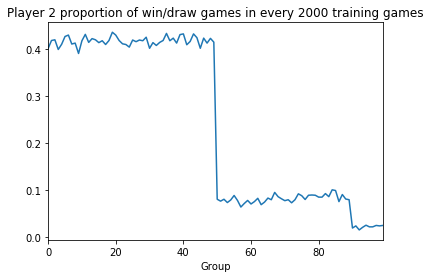

In [7]:
p1_2_train_scores_agg.plot()
plt.title('Player 2 proportion of win/draw games in every 2000 training games')
plt.xlabel('Group');

In [36]:
player1.set_epsilon(0)
player2.set_epsilon(0)
p1_2_real_game = train_computer_players(player1, player2, n_games=20000, adj_pX_epsilon=False, adj_pO_epsilon=False)

In [18]:
p1_2_real_scores, p1_2_real_scores_agg = compute_player_stats(p1_2_real_game, 'playerX')

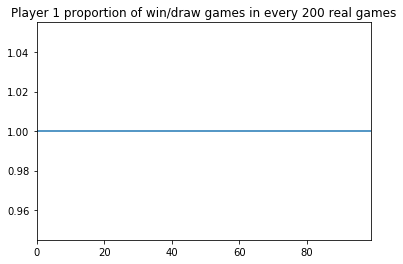

In [19]:
p1_2_real_scores_agg.plot()
plt.title('Player 1 proportion of win/draw games in every 200 real games');

In [25]:
p1_2_real_scores.score.mean()

0.99527

### Player 3 win stats

In [52]:
player3 = ttt_player('computer', 'O', epsilon=.9)

In [53]:
player1.set_epsilon(0)
player1.alpha = 0
p1_3_training_game = train_computer_players(player1, player3, adj_pX_epsilon=False)

In [54]:
len(player3.policy)


1751

In [55]:
state = ['X', '_', '_', '_', '_', '_', '_', '_', '_']
explore_policy(state, player3)

X _ _
_ _ _
_ _ _
Initial board state

X O _
_ _ _
_ _ _
Win probability = 0.00000000011908208

X _ O
_ _ _
_ _ _
Win probability = 0.00000000001614477

X _ _
O _ _
_ _ _
Win probability = 0.00000000039924351

X _ _
_ O _
_ _ _
Win probability = 0.50000000000000000

X _ _
_ _ O
_ _ _
Win probability = 0.00000000000690413

X _ _
_ _ _
O _ _
Win probability = 0.00000000101490790

X _ _
_ _ _
_ O _
Win probability = 0.00000000420971647

X _ _
_ _ _
_ _ O
Win probability = 0.00000000627944241



In [56]:
p1_3_train_scores, p1_3_train_scores_agg = compute_player_stats(p1_3_training_game, 'playerO')

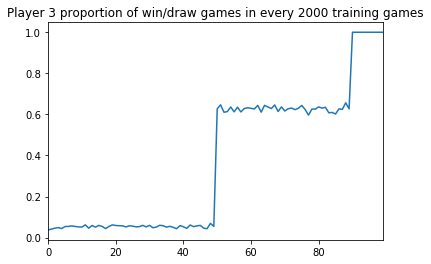

In [57]:
p1_3_train_scores_agg.plot()
plt.title('Player 3 proportion of win/draw games in every 2000 training games');

In [58]:
player3.set_epsilon(0)
p1_3_real_game = train_computer_players(player1, player3, n_games=20000, adj_pX_epsilon=False, adj_pO_epsilon=False)

In [59]:
p1_3_real_scores, p1_3_real_scores_agg = compute_player_stats(p1_3_real_game, 'playerO')

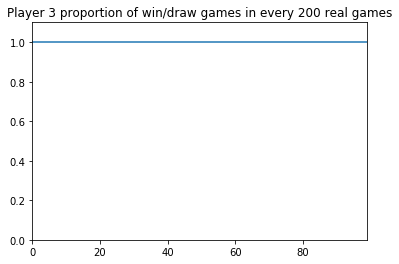

In [60]:
p1_3_real_scores_agg.plot()
plt.title('Player 3 proportion of win/draw games in every 200 real games')
plt.ylim(0,1.1);

In [87]:
p1_3_more_training = train_computer_players(player1, player3, n_games=50000,
                                            adj_pX_epsilon=False, adj_pO_epsilon=False)

In [88]:
p1_3_real_scores2, p1_3_real_scores_agg2 = compute_player_stats(p1_3_more_training, 'playerO')

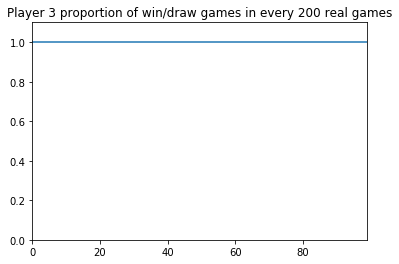

In [89]:
p1_3_real_scores_agg2.plot()
plt.title('Player 3 proportion of win/draw games in every 200 real games')
plt.ylim(0,1.1);

In [35]:
player3.epsilon

0

### Figure out if Player 3 is buggy

In [61]:
explore_policy(['X','X','_','O','O','_','_','_','_'], player1)

X X _
O O _
_ _ _
Initial board state

X X X
O O _
_ _ _
Win probability = 1.00000000000000000

X X _
O O X
_ _ _
Win probability = 0.60141331827904998

X X _
O O _
X _ _
Win probability = 0.07396816663904195

X X _
O O _
_ X _
Win probability = 0.13516021384178606

X X _
O O _
_ _ X
Win probability = 0.04719398929906676



In [62]:
explore_policy(['X','X','_','_','O','_','_','_','_'], player3)

X X _
_ O _
_ _ _
Initial board state

X X O
_ O _
_ _ _
Win probability = 0.50000000000000000

X X _
O O _
_ _ _
Win probability = 0.00000041041550522

X X _
_ O O
_ _ _
Win probability = 0.00000045601722802

X X _
_ O _
O _ _
Win probability = 0.00000000000000000

X X _
_ O _
_ O _
Win probability = 0.00000000073752089

X X _
_ O _
_ _ O
Win probability = 0.00000002651728188



In [63]:
explore_policy(['X','X','_','_','O','_','_','_','_'], player2)

X X _
_ O _
_ _ _
Initial board state

X X O
_ O _
_ _ _
Win probability = 0.50000000000000089

X X _
O O _
_ _ _
Win probability = 0.20712923576225445

X X _
_ O O
_ _ _
Win probability = 0.04768837211788724

X X _
_ O _
O _ _
Win probability = 0.14612109711042437

X X _
_ O _
_ O _
Win probability = 0.11772295798026493

X X _
_ O _
_ _ O
Win probability = 0.10103516433642107



In [64]:
explore_policy(['X','X','O','_','O','_','X','_','_'], player3)

X X O
_ O _
X _ _
Initial board state

X X O
O O _
X _ _
Win probability = 0.50000000000000000

X X O
_ O O
X _ _
Win probability = 0.00001075736654947

X X O
_ O _
X O _
Win probability = 0.00000004041652473

X X O
_ O _
X _ O
Win probability = 0.00000024234625168



In [159]:
a = a+.1*-a
print a

0.00257688760366


In [65]:
explore_policy(['X','X','O','_','O','_','X','_','_'], player2)

X X O
_ O _
X _ _
Initial board state

X X O
O O _
X _ _
Win probability = 0.50000000000000044

X X O
_ O O
X _ _
Win probability = 0.14089767531755445

X X O
_ O _
X O _
Win probability = 0.00079063669212751

X X O
_ O _
X _ O
Win probability = 0.13628249080899935



In [66]:
explore_policy(['X','X','O','_','O','_','X','_','O'], player1)

X X O
_ O _
X _ O
Initial board state

X X O
X O _
X _ O
Win probability = 1.00000000000000000

X X O
_ O X
X _ O
Win probability = 0.50000000000000044

X X O
_ O _
X X O
Win probability = 0.00292556693979397



In [67]:
explore_policy(['X','X','O','_','O','X','X','_','O'], player3)

X X O
_ O X
X _ O
Initial board state

X X O
O O X
X _ O
Win probability = 0.50000000000000000

X X O
_ O X
X O O
Win probability = 0.00000000059739192



In [96]:
test_computer(player1, n_games=1)

_ _ _
_ _ _
_ _ _

Player X's turn:
best move ixs:  [0, 1, 2, 3, 4, 5, 6, 7, 8]
max_prob:  0.5
X _ _
_ _ _
_ _ _

Player O's turn:
Enter the row and column you want to make a mark in, using the format x,y 2,2
X _ _
_ O _
_ _ _

Player X's turn:
best move ixs:  [1, 2, 3, 5, 6, 7, 8]
max_prob:  0.5
X _ _
_ O _
_ _ X

Player O's turn:
Enter the row and column you want to make a mark in, using the format x,y 3,2
X _ _
_ O _
_ O X

Player X's turn:
best move ixs:  [1]
max_prob:  0.5
X X _
_ O _
_ O X

Player O's turn:
Enter the row and column you want to make a mark in, using the format x,y 1,3
X X O
_ O _
_ O X

Player X's turn:
best move ixs:  [6]
max_prob:  0.5
X X O
_ O _
X O X

Player O's turn:
Enter the row and column you want to make a mark in, using the format x,y 2,1
X X O
O O _
X O X

Player X's turn:
best move ixs:  [5]
max_prob:  0.5
X X O
O O X
X O X

The game is a tie!


In [70]:
len(player3.policy)

1751

In [71]:
explore_policy(['_','_','_','_','_','_','_','_','_'], player1)

_ _ _
_ _ _
_ _ _
Initial board state

X _ _
_ _ _
_ _ _
Win probability = 0.50000000000000133

_ X _
_ _ _
_ _ _
Win probability = 0.50000234415819367

_ _ X
_ _ _
_ _ _
Win probability = 0.50000000286905710

_ _ _
X _ _
_ _ _
Win probability = 0.50000169618567569

_ _ _
_ X _
_ _ _
Win probability = 0.50000038831593496

_ _ _
_ _ X
_ _ _
Win probability = 0.50000317155810037

_ _ _
_ _ _
X _ _
Win probability = 0.50000000073787887

_ _ _
_ _ _
_ X _
Win probability = 0.50000222094548930

_ _ _
_ _ _
_ _ X
Win probability = 0.50000000860830762



In [72]:
explore_policy(['_','X','O','O','X','X','O','_','_'], player1)

_ X O
O X X
O _ _
Initial board state

X X O
O X X
O _ _
Win probability = 0.98986222020477732

_ X O
O X X
O X _
Win probability = 1.00000000000000000

_ X O
O X X
O _ X
Win probability = 0.05757427739361200



### What is Player 1's deal?

In [73]:
explore_policy(['X','X','_','_','O','_','_','_','_'], player3)

X X _
_ O _
_ _ _
Initial board state

X X O
_ O _
_ _ _
Win probability = 0.50000000000000000

X X _
O O _
_ _ _
Win probability = 0.00000041041550522

X X _
_ O O
_ _ _
Win probability = 0.00000045601722802

X X _
_ O _
O _ _
Win probability = 0.00000000000000000

X X _
_ O _
_ O _
Win probability = 0.00000000073752089

X X _
_ O _
_ _ O
Win probability = 0.00000002651728188



In [46]:
player3.set_epsilon(.5)
test_computer(player3, n_games=1)

_ _ _
_ _ _
_ _ _

Player X's turn:
Enter the row and column you want to make a mark in, using the format x,y 1,1
X _ _
_ _ _
_ _ _

Player O's turn:
X _ _
O _ _
_ _ _

Player X's turn:
Enter the row and column you want to make a mark in, using the format x,y 1,3
X _ X
O _ _
_ _ _

Player O's turn:
best move ixs:  [1, 5, 7, 8]
max_prob:  0.5
X _ X
O _ O
_ _ _

Player X's turn:
Enter the row and column you want to make a mark in, using the format x,y 1,2
X X X
O _ O
_ _ _

Player X wins!


In [74]:
explore_policy(['X','_','X','O','_','_','_','_','_'], player3)

X _ X
O _ _
_ _ _
Initial board state

X O X
O _ _
_ _ _


KeyError: ('X', 'O', 'X', 'O', '_', '_', '_', '_', '_')

In [78]:
explore_policy(['X','_','_','O','_','_','_','_','_'], player1)

X _ _
O _ _
_ _ _
Initial board state

X X _
O _ _
_ _ _
Win probability = 0.88209304572364799

X _ X
O _ _
_ _ _
Win probability = 0.87876867161072036

X _ _
O X _
_ _ _
Win probability = 0.99999997770097437

X _ _
O _ X
_ _ _
Win probability = 0.50000764972816292

X _ _
O _ _
X _ _
Win probability = 0.63998814404340776

X _ _
O _ _
_ X _
Win probability = 0.69013965920311970

X _ _
O _ _
_ _ X
Win probability = 0.77824843059546378



In [75]:
explore_policy(['X','X','O','_','O','_','X','_','_'], player3)

X X O
_ O _
X _ _
Initial board state

X X O
O O _
X _ _
Win probability = 0.50000000000000000

X X O
_ O O
X _ _
Win probability = 0.00001075736654947

X X O
_ O _
X O _
Win probability = 0.00000004041652473

X X O
_ O _
X _ O
Win probability = 0.00000024234625168



# Mental Bookmark
- train faster
- Expert O did worse than Challenger O against Random X. Why? 
- Changing P1's alpha to 0 eliminated the issue where P3 didn't explore the possibility space (I think P1 was always playing the same move because it learned that that move was "better," but that was just because P3 played that position poorly and lost.)
- P1 doesn't prefer corners. What if I train it against a P2 with a constant epsilon = .9? Then it should learn that corners are better because corners lead to more game paths where O loses.  
-- Nope, X prefers the center if O is moving randomly (or close to randomly). But why? I worked out the numbers and corners should be slightly better.
- consider "shaping." Player 3 learns faster against expert Player 1 than if Player 1 is set to explore? Create these players:  
-- Expert Player X, explores all moves and is an expert player  
-- Apprentice Player O, trains against Expert X and therefore only explores the best moves for X (should train faster than New Expert O)  
-- Random Player, compare win rate when an Expert plays Random vs. when Apprentice plays Random (Apprentice should perform poorly when Random makes non-Expert moves)
-- New Expert O, trains against Expert X while X epsilon > .5. Should perform better against Random than Apprentice.  
- maybe create an argument to remove np.isclose and train faster
- create readme
- create a module that I can import?
- give computer players one policy dictionary to share?  
-- they'll train twice as fast, and have all entries

## Stuff to write about
- Implementation  
--  training player3 with player1's learning rate != 0 somehow resulted in p3 not exploring a lot of paths. I think it's because p1's policy changed a bunch in response to p3's erratic behavior as a learner, and thus p1 learned some new "best" moves and stuck with those for a while.  
-- have to continue training after stopping exploration, to let policies settle


- Interesting stuff  
-- this algo will win either quickly or slowly if it has equal probability of winning with either. As will minimax if you don't do alpha-beta pruning.  
-- if board is [\_,X,O,\_,X,\_,O,\_,\_], any move by X has 100% chance of winning!
-- "shaping behavior": train against expert opponent to explore the best moves faster